In [9]:
# path, thres, thres_ear 설정

path = 'shorts_study.mp4'# default: None, * 휴대폰 촬영 영상 -> 이후 코드에서 180도 회전 주석 확인
# example video: shorts12: , short16:측정불가, shorts17: 2명이상, shorts26: 안구운동

thres = 0.45 # thres < 0.5 (select in 0.40 ~ 0.47)  => e.g. [thres|----|(1-thres)]  
thres_ = 1-thres
thres_ear = 0.7 # thres_ear >= 0.5 => up
range_w = 50 # 좌측부터 2,3번째 그리드의 x좌표 간격에 각각 +,- 값 
                
import cv2
import mediapipe as mp
import pandas as pd
import math
import time
pd.set_option('mode.chained_assignment', None)
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh
FACEMESH_LEFT_EYE = frozenset([(263, 249), (249, 390), (390, 373), (373, 374),
                               (374, 380), (380, 381), (381, 382), (382, 362),
                               (263, 466), (466, 388), (388, 387), (387, 386),
                               (386, 385), (385, 384), (384, 398), (398, 362)])
FACEMESH_RIGHT_EYE = frozenset([(33, 7), (7, 163), (163, 144), (144, 145),
                                (145, 153), (153, 154), (154, 155), (155, 133),
                                (33, 246), (246, 161), (161, 160), (160, 159),
                                (159, 158), (158, 157), (157, 173), (173, 133)])
FACEMESH_CONTOURS = frozenset().union(*[FACEMESH_LEFT_EYE, FACEMESH_RIGHT_EYE])
FACEMESH_RIGHT_IRIS = frozenset([(469, 470), (470, 471), (471, 472),(472, 469)])
FACEMESH_LEFT_IRIS = frozenset([(474, 475), (475, 476), (476, 477),(477, 474)])
FACEMESH_IRISES = frozenset().union(*[FACEMESH_LEFT_IRIS, FACEMESH_RIGHT_IRIS])
FACEMESH_LEFT_EYE = frozenset([(263, 249), (249, 390), (390, 373), (373, 374),
                       (374, 380), (380, 381), (381, 382), (382, 362),
                       (263, 466), (466, 388), (388, 387), (387, 386),
                       (386, 385), (385, 384), (384, 398), (398, 362)])
FACEMESH_RIGHT_EYE = frozenset([(33, 7), (7, 163), (163, 144), (144, 145),
                                (145, 153), (153, 154), (154, 155), (155, 133),
                                (33, 246), (246, 161), (161, 160), (160, 159),
                                (159, 158), (158, 157), (157, 173), (173, 133)])
FACEMESH_EYES = frozenset().union(*[FACEMESH_LEFT_EYE, FACEMESH_RIGHT_EYE])
right_under = [7,33,133,144,145,153,154,155,163]
left_under = [249,263,362,373,374,380,381,382,390]
under = frozenset().union(right_under,left_under) # under에는 양끝 눈꺼풀도 포함되어 있음
# For webcam input:
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

# variable
ok_flag = 1
total_landmarks=[]
dir_r = None
dir_l = None
dir_ = None    
aaaa=1
time_list = []

if path:
    cap = cv2.VideoCapture(path)
else:
    cap = cv2.VideoCapture(0)
with mp_face_mesh.FaceMesh( max_num_faces=1, refine_landmarks=True,
    min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:

    while cap.isOpened() and ok_flag == 1:
        success, image = cap.read()
        aaaa+=1 # frame 개수
        image=image[::-1] # 주의, 폰으로 촬영시 180도 뒤집히는 현상
        if not success:
            print("Ignoring empty camera frame.")
            # If loading a video, use 'break' instead of 'continue'.
            continue
            
        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(image)
        x = image.shape[1] # height
        y = image.shape[0] # width

        # Draw the face mesh annotations on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        if results.multi_face_landmarks:
            for face_landmarks in (results.multi_face_landmarks):
                begin = time.time()
                # Drawing base line(facemesh)
                # eyes
                mp_drawing.draw_landmarks(
                    image=image,
                    landmark_list=face_landmarks,
                    connections=FACEMESH_CONTOURS,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style())
                # irises
                mp_drawing.draw_landmarks(
                    image=image,
                    landmark_list=face_landmarks,
                    connections=mp_face_mesh.FACEMESH_IRISES,
                    # mp_face_mesh
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_iris_connections_style())
                total_landmarks.append(face_landmarks.landmark)

                # Make DataFrames------------------------------------------------------------
                # iris data frame
                irises=[] # temporary list
                for iris, _ in FACEMESH_IRISES:
                    irises.append(iris)
                irises.sort() # order
                total = [] # to be iris dataframe
                for n,_ in enumerate(irises):
                    n+=1
                    # 좌표 x,y,z값 순서 각 4개씩 (오른쪽눈 < 왼쪽눈) 
                    if n <=len(FACEMESH_LEFT_IRIS):
                        direction = 'right'
                    else:
                        n-=len(FACEMESH_LEFT_IRIS)
                        direction = 'left'
                    now = [_,direction ,face_landmarks.landmark[_].x,face_landmarks.landmark[_].y,face_landmarks.landmark[_].z] # info in this time
                    total.append(now) 
                iris_df = pd.DataFrame(total, columns = ['idx','dir','x','y','z']) # idx: landmark, dir: right/left
                
                # iris / normalized data => resize to origin and to int
                iris_df['x'] = iris_df['x']*x
                iris_df['y'] = iris_df['y']*y
                iris_df['x'] = iris_df['x'].astype('int64')
                iris_df['y'] = iris_df['y'].astype('int64')

                # eyes data frame
                eyes=[] # temporary list
                for eye, _ in FACEMESH_EYES:
                    eyes.append(eye)
                    eyes.append(_)
                eyes = list(set(eyes))
                eyes.sort() # order
                total = [] # to be eyes dataframe
                for n,_ in enumerate(eyes):
                    n+=1
                    # 좌표 x,y,z값 순서 각 16개씩 (오른쪽눈 < 왼쪽눈) 
                    if n <= len(FACEMESH_LEFT_EYE): 
                        direction = 'right'     
                    else:
                        n-=int(len(FACEMESH_LEFT_EYE))
                        direction = 'left'
                    if _ in under:
                        loc = 'under'
                    else:
                        loc = 'up'
                    now = [_,direction ,face_landmarks.landmark[_].x,face_landmarks.landmark[_].y,face_landmarks.landmark[_].z,loc] # info in this time
                    total.append(now)
                eyes_df = pd.DataFrame(total, columns = ['idx','dir','x','y','z','loc']) # idx: landmark, dir: right/left, loc: up/down
                
                # eyes / normalized data => resize to origin and to int
                eyes_df['x'] = eyes_df['x']*x
                eyes_df['y'] = eyes_df['y']*y
                eyes_df['x'] = eyes_df['x'].astype('int64')
                eyes_df['y'] = eyes_df['y'].astype('int64')
                
                # Gaze Point Estimation------------------------------------------------------------
                
                
                # 오른쪽 동공의 각 끝 좌표
                n469_x, n469_y = iris_df[iris_df['idx']==469].x,iris_df[iris_df['idx']==469].y
                n471_x, n471_y = iris_df[iris_df['idx']==471].x,iris_df[iris_df['idx']==471].y
                # 왼쪽 동공의 각 끝 좌표
                n474_x, n474_y = iris_df[iris_df['idx']==474].x,iris_df[iris_df['idx']==474].y
                n476_x, n476_y = iris_df[iris_df['idx']==476].x,iris_df[iris_df['idx']==476].y
                
                # 오른쪽 동공의 중심좌표
                dot_r = ((int(n469_x) + int(n471_x)) / 2, (int(n469_y) + int(n471_y)) / 2)
                # 왼쪽 동공의 중심좌표
                dot_l = ((int(n474_x) + int(n476_x)) / 2, (int(n474_y) + int(n476_y)) / 2)

                # 오른쪽 눈꺼풀의 각 끝 좌표와 길이
                n33 = (eyes_df[eyes_df['idx']==33].x,eyes_df[eyes_df['idx']==33].y)
                n133 = (eyes_df[eyes_df['idx']==133].x,eyes_df[eyes_df['idx']==133].y) 
                dist_r = math.dist(n33,n133)
                # 왼쪽 눈꺼풀의 각 끝 좌표와 길이
                n263 = (eyes_df[eyes_df['idx']==263].x,eyes_df[eyes_df['idx']==263].y)
                n362 = (eyes_df[eyes_df['idx']==362].x,eyes_df[eyes_df['idx']==362].y)
                dist_l = math.dist(n263,n362)

                # 오른쪽 밑 눈꺼풀
                n145 = (eyes_df[eyes_df['idx']==145].x,eyes_df[eyes_df['idx']==145].y)
                # 왼쪽 밑 눈꺼풀
                n374 = (eyes_df[eyes_df['idx']==374].x,eyes_df[eyes_df['idx']==374].y)
                
                # gaze point line val
                # 눈 좌표 값 방향기준
                right_line_x = ((n33[0][1]-range_w)/2)/2
                rightcenter_line_x = ((n33[0][1]-range_w)/2) + ((n33[0][1]-range_w)/2)/2
                center_line_x = (n263[0][17]+range_w - (n33[0][1]-range_w))/2 + (n33[0][1]-range_w)
                leftcenter_line_x = (n263[0][17]+range_w)+(x-(n263[0][17]+range_w))/4
                left_line_x = (n263[0][17]+range_w) + (x-(n263[0][17]+range_w))*3/4
                
                up_line_y = eyes_df[eyes_df['idx']==33].y[1]/2
                middle_line_y = eyes_df[eyes_df['idx']==33].y[1] + (y*.75 -  eyes_df[eyes_df['idx']==33].y[1])/2
                down_line_y = y*.75+y*.125
                
                # 오른쪽 눈 방향 (좌우)
                r_ratio = round((math.dist(dot_r, n133)/dist_r),5) # if ratio < thres: left
                if r_ratio:
                    if r_ratio < thres:
                        dir_r = 'Right'
                    elif r_ratio > thres_:
                        dir_r = 'Left'
                    else:
                        dir_r = 'Center'
                # 왼쪽 눈 방향 (좌우)
                l_ratio = round((math.dist(dot_l, n263)/dist_l),5) # if ratio < thres: left                
                if l_ratio:
                    if l_ratio < thres:
                        dir_l = 'Right'
                    elif l_ratio > thres_:
                        dir_l = 'Left'
                    else:
                        dir_l = 'Center'
                # 통합 눈 방향 (좌우)
                if dir_r == dir_l:
                    dir_ = dir_r
                    if dir_r == 'Right':
                        gaze_line_x = left_line_x
                    else:
                        gaze_line_x = right_line_x
                elif ((dir_r =='Right') and (dir_l =='Left')) or ((dir_r == 'Left') and (dir_l == 'Right')):
                    dir_ = 'Center' # 양 끝 값일 때, 중앙으로
                    gaze_line_x = center_line_x
                else: # [rightcenter, leftcenter, centerright, centerleft]
                    dir_ = [dir_r,dir_l]
                    if ('Right' in dir_) and ('Center' in dir_):
                        dir_ = 'RightCenter'
                        gaze_line_x = leftcenter_line_x
                    if ('Left' in dir_) and ('Center' in dir_):
                        dir_ = 'LeftCenter'
                        gaze_line_x = rightcenter_line_x

#                 up_r = iris_df[iris_df['idx']==472]['y'][3] - eyes_df[eyes_df['idx']==145].y[4] # if up<0: up
#                 up_l = iris_df[iris_df['idx']==477]['y'][7] - eyes_df[eyes_df['idx']==374].y[20] # if up<0: up

                # EAR ratio--------------------------------------------------
                # 오른쪽 눈 방향 (상하) : (|161-163|+|157-154|)/2*|133-33|*1/100
                n161 = (eyes_df[eyes_df['idx']==161].x,eyes_df[eyes_df['idx']==161].y)
                n163 = (eyes_df[eyes_df['idx']==163].x,eyes_df[eyes_df['idx']==163].y)
                n154 = (eyes_df[eyes_df['idx']==154].x,eyes_df[eyes_df['idx']==154].y)
                n157 = (eyes_df[eyes_df['idx']==157].x,eyes_df[eyes_df['idx']==157].y)
                right_ear = (abs(math.dist(n161,n163))+abs(math.dist(n157,n154)))/2*abs(math.dist(n133,n33))/1000
                # 왼쪽 눈 방향 (상하) : (|384-381|+|388-390|)/2*|263-362|*1/100
                n381 = (eyes_df[eyes_df['idx']==381].x,eyes_df[eyes_df['idx']==381].y)
                n384 = (eyes_df[eyes_df['idx']==384].x,eyes_df[eyes_df['idx']==384].y)
                n388 = (eyes_df[eyes_df['idx']==388].x,eyes_df[eyes_df['idx']==388].y)
                n390 = (eyes_df[eyes_df['idx']==390].x,eyes_df[eyes_df['idx']==390].y)
                left_ear = (abs(math.dist(n384,n381))+abs(math.dist(n388,n390)))/2*abs(math.dist(n263,n362))/1000
                
                # Right iris(468) z vs Left iris(473) z: higher value is closer camera.
                if face_landmarks.landmark[468].z > face_landmarks.landmark[473].z:
                    using_ear = right_ear
                else:
                    using_ear = left_ear
                if using_ear <= 0.15:
                    ear = 'CLOSE'
                    gaze_line_y = down_line_y
                elif (using_ear > 0.15) and (using_ear <= thres_ear/2):# thres_ear_ = thres_ear/2
                    ear = 'DOWN'
                    gaze_line_y = down_line_y
                elif (using_ear > 0.4) and (using_ear < thres_ear): # thres_ear = 0.7
                    ear = 'MIDDLE'
                    gaze_line_y = middle_line_y
                else:
                    ear = 'UP'
                    gaze_line_y = up_line_y
                    
#               Grid line--------------------------------------------------
                cv2.line(image,(n33[0][1]-range_w,0),(n33[0][1]-range_w,y),(255,0,0),3) # n33[0][1]= n33_x, range_w = 50
                cv2.line(image,(n263[0][17]+range_w,0),(n263[0][17]+range_w,y),(255,0,0),3)

                cv2.line(image,(int((n33[0][1]-range_w)/2),0),(int((n33[0][1]-range_w)/2),y),(255,0,0),3)
                cv2.line(image,(int((x-(n263[0][17]+range_w))/2+(n263[0][17]+range_w)),0),(int((x-(n263[0][17]+range_w))/2+(n263[0][17]+range_w)),y),(255,0,0),3) # n263[0][17]= n263_x
                
                cv2.line(image,(0,int(y*0.75)),(x,int(y*0.75)),(255,0,0),1) # 책상선
                cv2.line(image,(0,eyes_df[eyes_df['idx']==33].y[1]),(x,eyes_df[eyes_df['idx']==33].y[1]),(255,0,0),1) # 오른쪽 바깥 눈꼬리 기준
                #cv2.line(image,(0,int(face_landmarks.landmark[10].y*y)),(x,int(face_landmarks.landmark[10].y*y)),(255,0,0),3) # 이마라인선 but, down과 middle의 기준이 애매함, 눈꼬리 기준으로 위아래 나누는게 더 좋을듯
                
                # gaze point line --------------------------------------------------
#                 print(gaze_line_x)
#                 print(gaze_line_y)
                if ear != 'UP':
                    cv2.line(image,(int(face_landmarks.landmark[468].x*x),int(face_landmarks.landmark[468].y*y)),(int(gaze_line_x)-50, int(gaze_line_y)),(255,0,0),2) 
                    cv2.line(image,(int(face_landmarks.landmark[473].x*x),int(face_landmarks.landmark[473].y*y)),(int(gaze_line_x)+50, int(gaze_line_y)),(255,0,0),2)
                
                
        
                # put text --------------------------------------------------   
                if dir_:
                    org=(700,700)
                    font=cv2.FONT_HERSHEY_SIMPLEX
                    cv2.putText(image,dir_,org,font,1,(255,0,0),2)
                    size, BaseLine=cv2.getTextSize(dir_,font,1,2)
                if ear:
                    org=(700,600)
                    font=cv2.FONT_HERSHEY_SIMPLEX
                    cv2.putText(image,ear,org,font,1,(255,0,0),2)
                    size, BaseLine=cv2.getTextSize(ear,font,1,2)
                # time --------------------------------------------------
                end = time.time()
                t = end - begin # 현재 frame 시간 값
                
#                 if obj in positive_list: # 공부하는 시간은 frame시간 더함
#                     study_time += t # 순공시간
#                 else:
#                     continue    
#                 now = [t,obj] # 현재 행
#                 time_list.append(now) # sum 했을 때 => 전체 시간 값

    
#             cv2.imshow('MediaPipe', cv2.flip(image, 0))         # Flip the image horizontally for a selfie-view display.
            cv2.imshow('MediaPipe', image)
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                ok_flag=0
cap.release()
cv2.destroyAllWindows()
print(aaaa)

789


NameError: name 'aaaa' is not defined

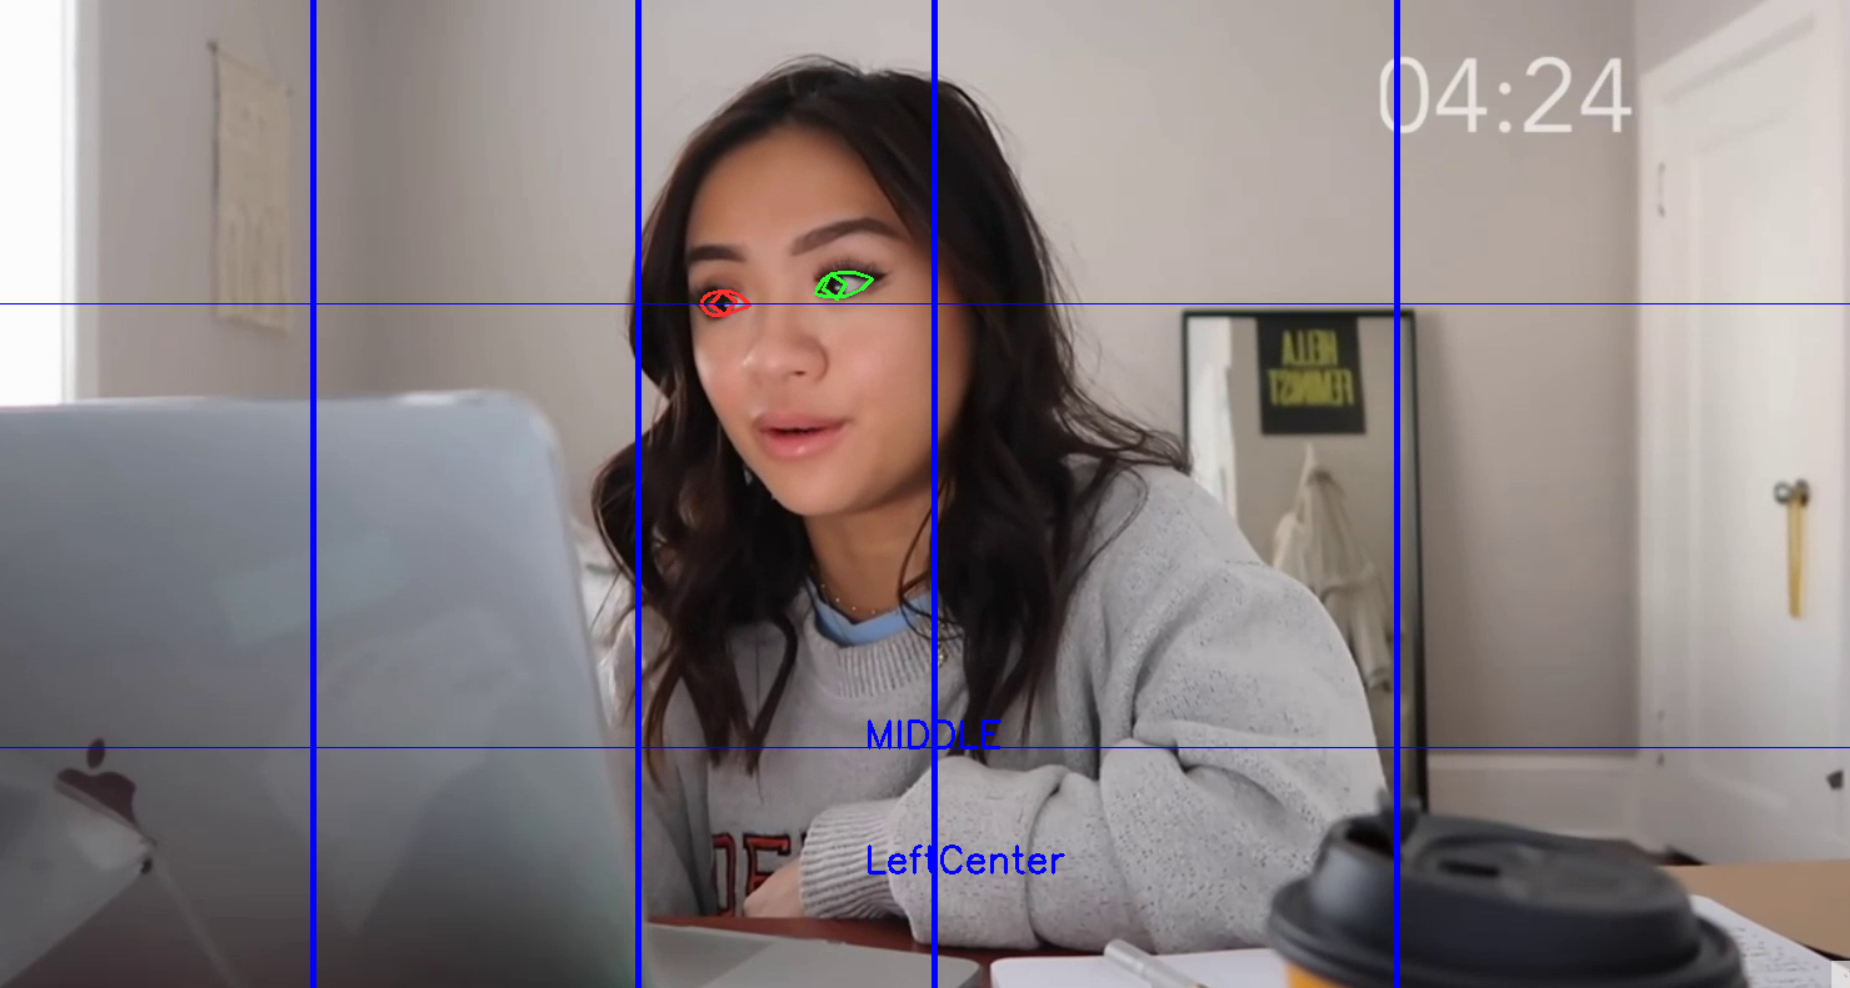